In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import torch
from tqdm import tqdm

from sklearn.decomposition import PCA

In [2]:
kB = 0.0083144621
temperature = 300
biasFactor = 6.0
_deltaT = temperature*(biasFactor-1)

In [3]:
_totalBias = np.load("/home/arminshzd/Documents/GADES/examples/sulfadiazine/PCA/biases/bias_179710546_10001.npy")

In [4]:
FE = -((temperature+_deltaT)/_deltaT)*_totalBias

In [5]:
print(FE.min(), FE.max())

-109.50330175804355 -0.2645917949377841


In [6]:
FE -= np.min(FE)

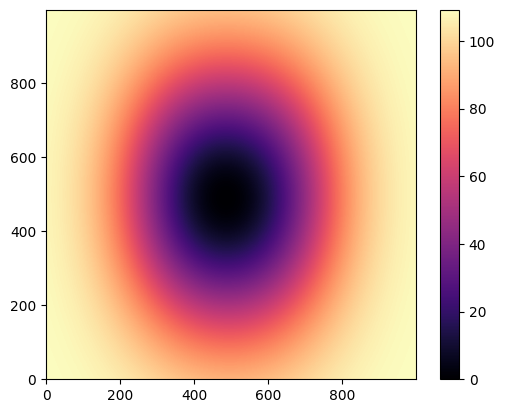

In [7]:
plt.imshow(FE, cmap='magma', norm='linear', aspect='equal', interpolation='none', origin='lower')
plt.colorbar()
plt.show()

In [8]:
traj = md.load("traj_metad.dcd", top="../em.gro")
X = torch.from_numpy(traj.xyz)
boxvectors = torch.from_numpy(traj.unitcell_vectors)

In [9]:
cv1 = torch.jit.load("cv1.pt")
cv2 = torch.jit.load("cv2.pt")

In [10]:
cv1_vals = torch.zeros(X.shape[0], )
cv2_vals = torch.zeros(X.shape[0], )
for i in tqdm(range(X.shape[0])):
    with torch.no_grad():
        cv1_vals[i] = (cv1(X[i, ...], boxvectors[i, ...]))
        cv2_vals[i] = (cv2(X[i, ...], boxvectors[i, ...]))

100%|██████████| 50000/50000 [00:08<00:00, 6169.52it/s]


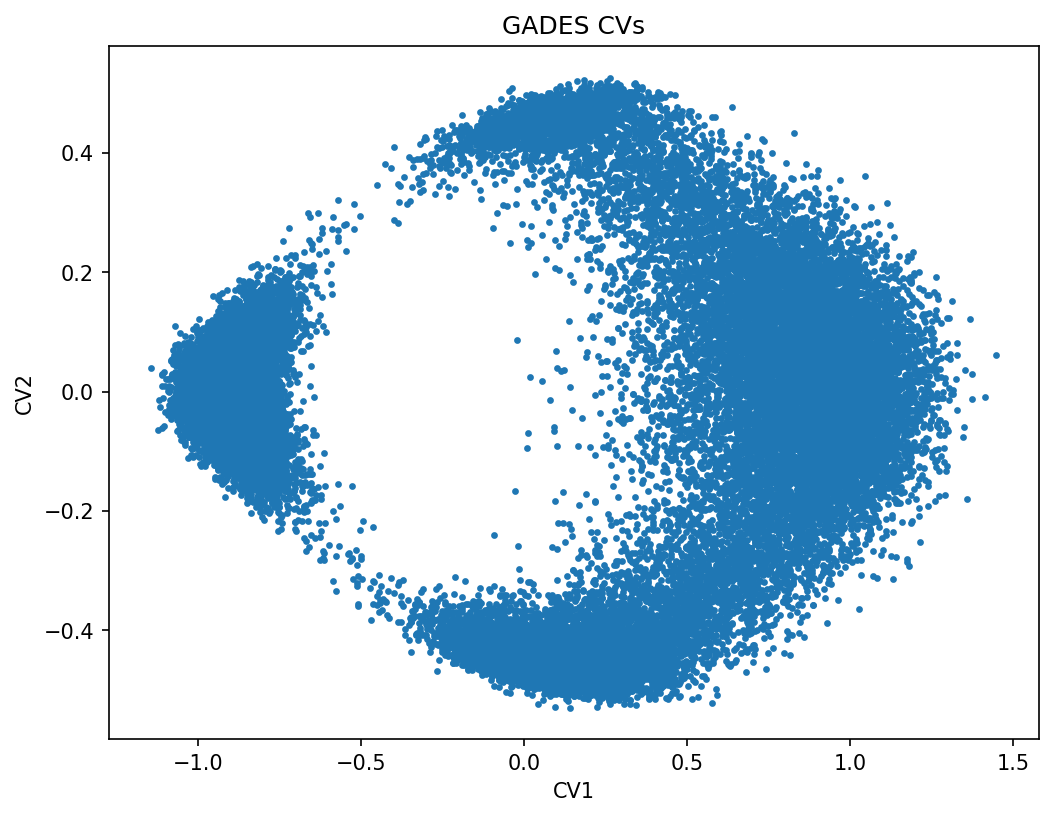

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)
ax.scatter(cv1_vals, cv2_vals, s=5)
ax.set_title("GADES CVs")
ax.set_xlabel("CV1")
ax.set_ylabel("CV2")
plt.show()

In [12]:
def get_colvars(traj):

    CVs_O = md.compute_dihedrals(traj, [[9, 8, 5, 0], 
                                      [1, 2, 11, 12],
                                      [2, 11, 12, 13],
                                      [11, 12, 13, 16]])
    
    features = np.concatenate([np.sin(CVs_O), np.cos(CVs_O)], axis=1)
    
    pca = PCA(n_components=3)
    CVs = pca.fit_transform(features)
    
    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(CVs[:, 0], CVs[:, 1], bins=100)

    # Assign count to each point’s bin
    xidx = np.searchsorted(xedges, CVs[:, 0]) - 1
    yidx = np.searchsorted(yedges, CVs[:, 1]) - 1

    # Clip indices to avoid out-of-bounds
    xidx = np.clip(xidx, 0, counts.shape[0] - 1)
    yidx = np.clip(yidx, 0, counts.shape[1] - 1)

    kde = counts[xidx, yidx]
    return CVs_O, CVs, kde

In [13]:
CV_O, CVs, kds = get_colvars(traj)

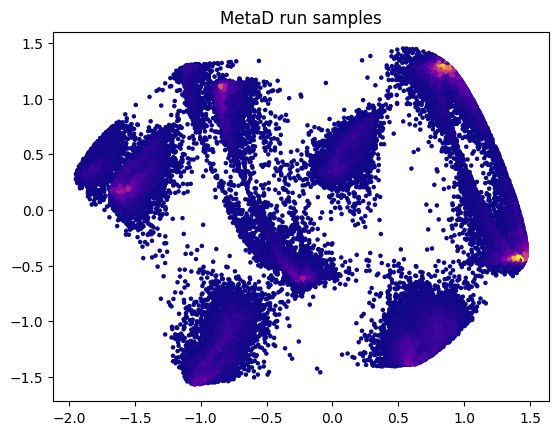

In [14]:
plt.scatter(CVs[:, 0], CVs[:, 1], c=kds, cmap="plasma", s=5)
plt.title("MetaD run samples")
plt.show()

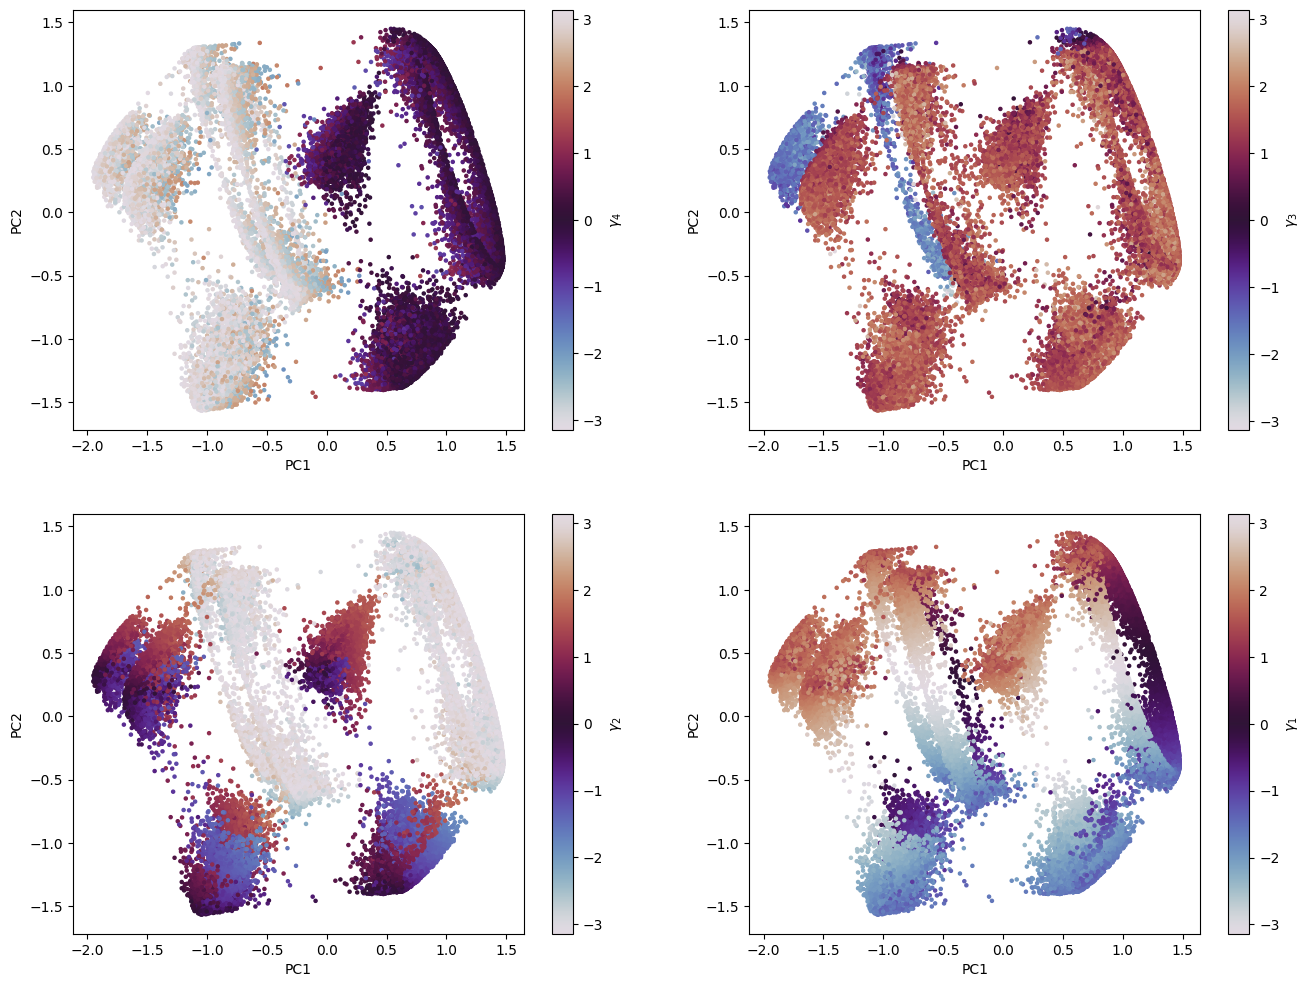

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axs = axs.flatten()
for i in range(len(axs)):
    cnt = axs[i].scatter(CVs[:, 0], CVs[:, 1], c=CV_O[:, i], cmap="twilight", s=5)
    axs[i].set_xlabel("PC1")
    axs[i].set_ylabel("PC2")
    cbar = fig.colorbar(cnt, ax=axs[i])
    cbar.set_label(fr"$\gamma_{4 - i}$")
    
#fig.set_label("MetaD run samples")
plt.show()

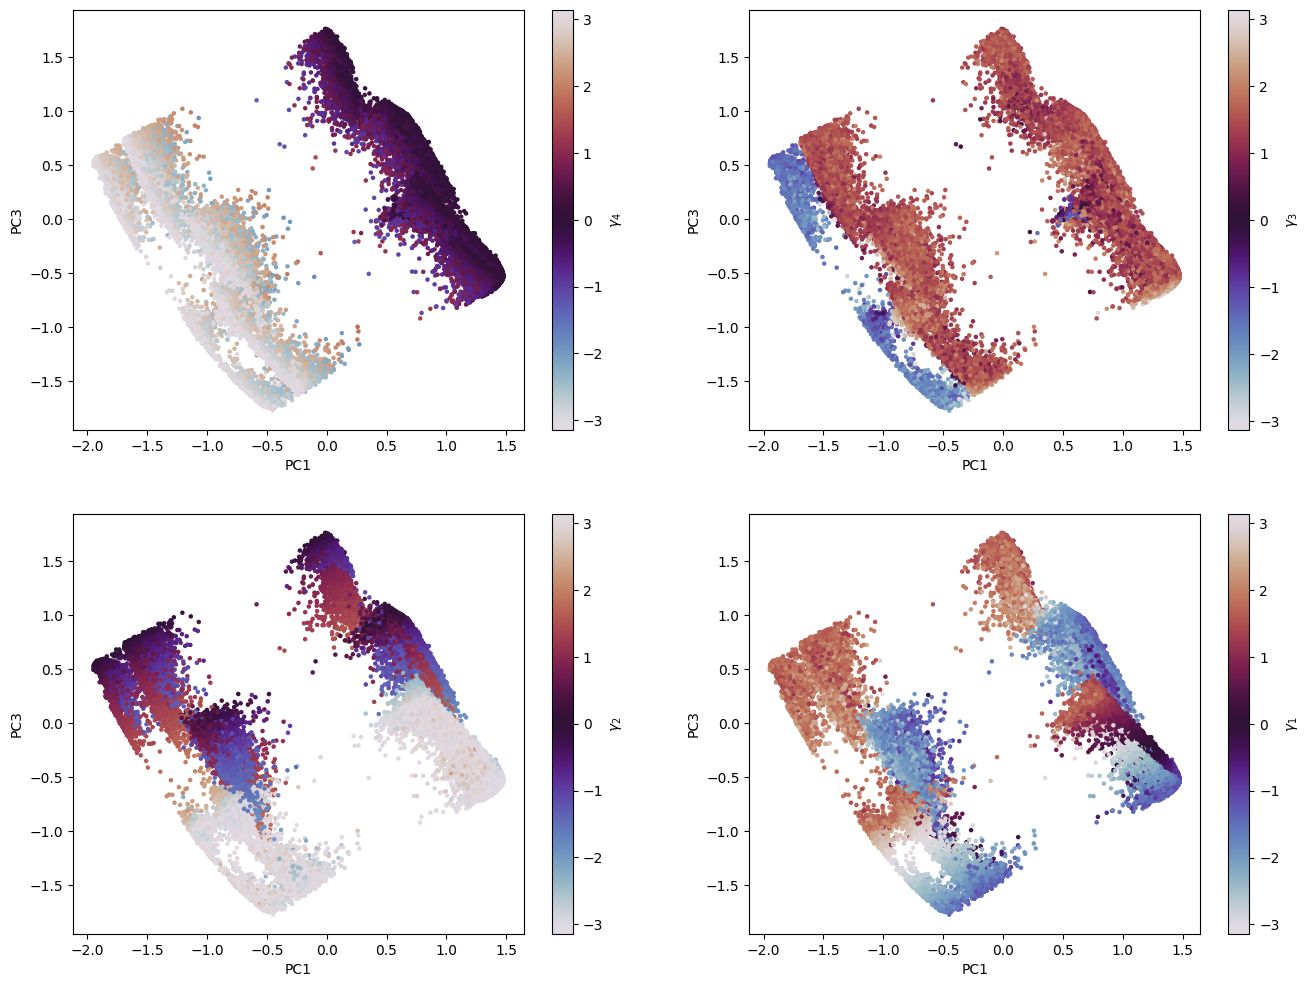

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axs = axs.flatten()
for i in range(len(axs)):
    cnt = axs[i].scatter(CVs[:, 0], CVs[:, 2], c=CV_O[:, i], cmap="twilight", s=5)
    axs[i].set_xlabel("PC1")
    axs[i].set_ylabel("PC3")
    cbar = fig.colorbar(cnt, ax=axs[i])
    cbar.set_label(fr"$\gamma_{4 - i}$")
    
#fig.set_label("MetaD run samples")
plt.show()

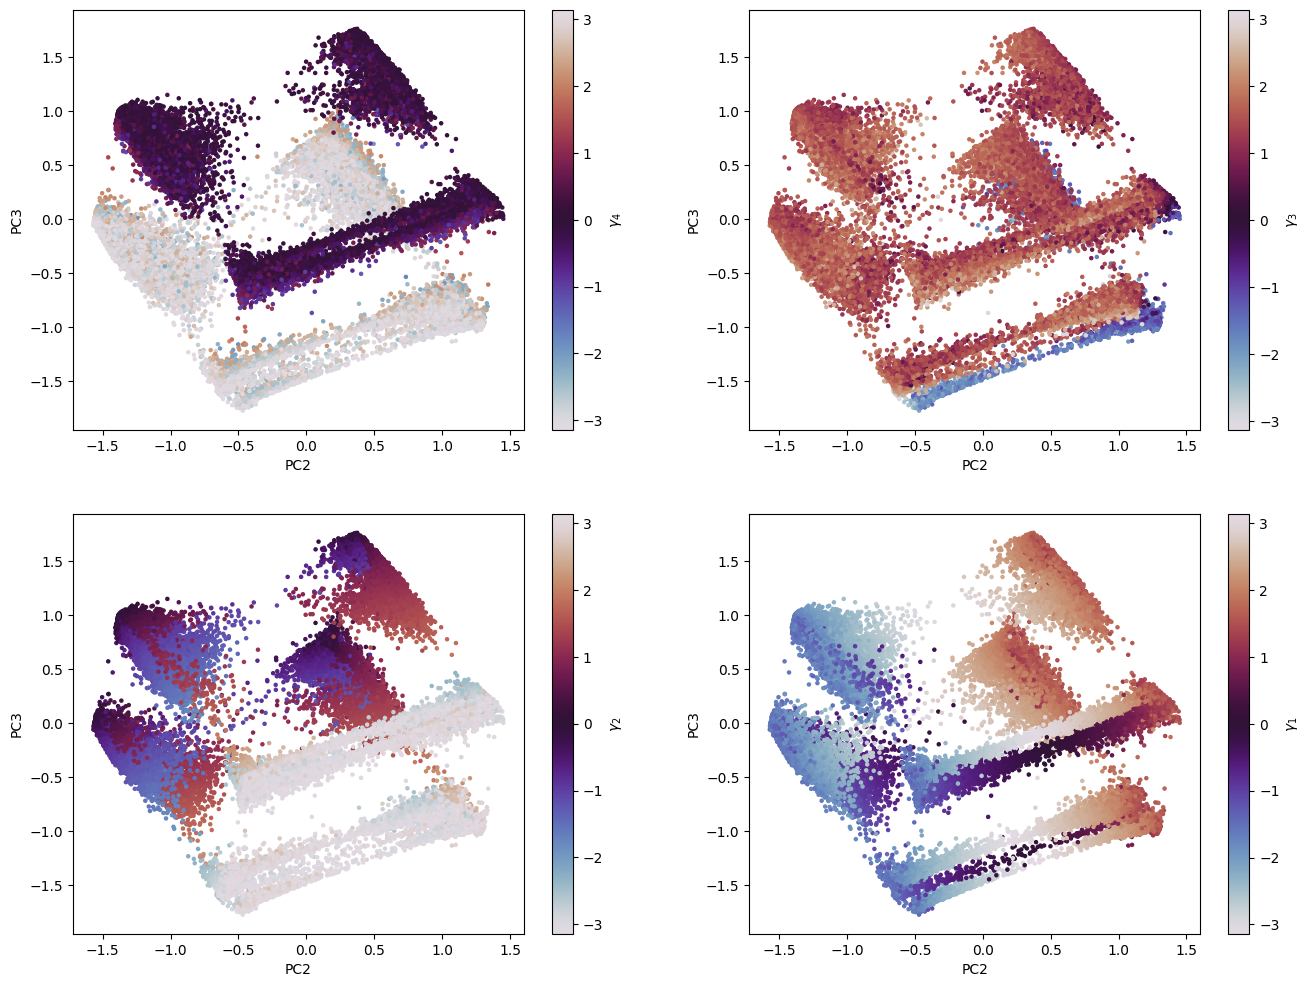

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axs = axs.flatten()
for i in range(len(axs)):
    cnt = axs[i].scatter(CVs[:, 1], CVs[:, 2], c=CV_O[:, i], cmap="twilight", s=5)
    axs[i].set_xlabel("PC2")
    axs[i].set_ylabel("PC3")
    cbar = fig.colorbar(cnt, ax=axs[i])
    cbar.set_label(fr"$\gamma_{4 - i}$")
    
#fig.set_label("MetaD run samples")
plt.show()

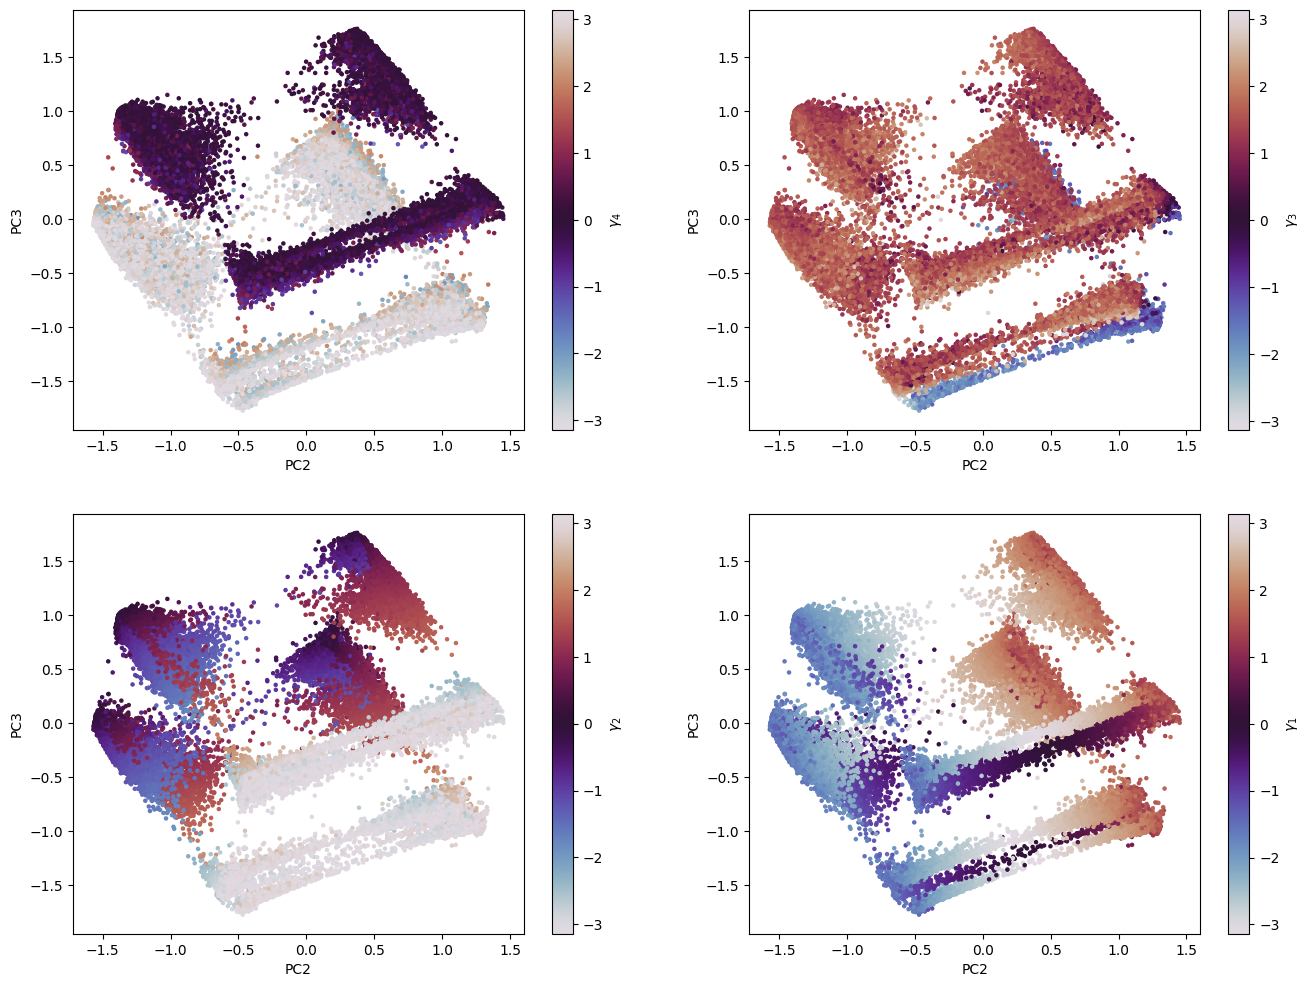

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axs = axs.flatten()
for i in range(len(axs)):
    cnt = axs[i].scatter(CVs[:, 1], CVs[:, 2], c=CV_O[:, i], cmap="twilight", s=5)
    axs[i].set_xlabel("PC2")
    axs[i].set_ylabel("PC3")
    cbar = fig.colorbar(cnt, ax=axs[i])
    cbar.set_label(fr"$\gamma_{4 - i}$")
    
#fig.set_label("MetaD run samples")
plt.show()

In [23]:
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.colors as mcolors

mpl_cmap = cm.get_cmap('twilight')
plotly_colorscale = [
    [i / 255, mcolors.to_hex(mpl_cmap(i / 255))]
    for i in range(256)
]

fig = px.scatter_3d(x=CVs[:, 0], y=CVs[:, 1], z=CVs[:, 2], 
                    color=CV_O[:, 1],
                     color_continuous_scale=plotly_colorscale)
fig.update_traces(marker=dict(size=3))
fig.show()

/tmp/ipykernel_2559803/1540623606.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl_cmap = cm.get_cmap('twilight')


In [19]:
import numpy as np
import pandas as pd

def assign_weights_to_trajectory(bias: np.ndarray,
                                 x_vals: np.ndarray,
                                 y_vals:np.ndarray,
                                 min_x: float, max_x: float,
                                 min_y: float, max_y: float) -> pd.DataFrame:
    """
    Assigns weights from a 2D grid to each (x, y) point in a trajectory based on which grid cell the point falls into.

    Args:
        bias (np.ndarray): 2D array of shape (n_grid_x, n_grid_y) with bias on a regular grid.
        x_vals (np.ndarray): Array of shape (T, ).
        y_vals (np.ndarray): Array of shape (T, ).
        min_x (float): Minimum x value of the grid.
        max_x (float): Maximum x value of the grid.
        min_y (float): Minimum y value of the grid.
        max_y (float): Maximum y value of the grid.

    Returns:
        pd.DataFrame: DataFrame with columns ['x', 'y', 'weight'] for each timestep.
    """
    n_grid_x = bias.shape[0]
    n_grid_y = bias.shape[1]
    # Compute bin width
    dx = (max_x - min_x) / n_grid_x
    dy = (max_y - min_y) / n_grid_y

    # Map coordinates to indices
    ix = np.floor((x_vals - min_x) / dx).astype(int)
    iy = np.floor((y_vals - min_y) / dy).astype(int)

    # Clamp indices to valid range
    ix = np.clip(ix, 0, n_grid_x - 1)
    iy = np.clip(iy, 0, n_grid_y - 1)

    # Extract weights
    bias_vals = bias[ix, iy]
    weights = np.exp(bias_vals/temperature/kB)

    return pd.DataFrame({'CV1': x_vals, 'CV2': y_vals, 'bias': bias_vals, "weight": weights})

In [20]:
data_df = assign_weights_to_trajectory(_totalBias,
                                 cv1_vals.numpy(),
                                 cv2_vals.numpy(),
                                 -3.5, 3.5,
                                 -2, 2)

In [21]:
def get_free_energy_surface(data_df, x, y, temperature, kB, range):
    # Histogram the weighted trajectory
    hist, x_edges, y_edges = np.histogram2d(data_df[x], data_df[y], 
                                            bins=100,
                                            range=range,
                                            weights=data_df['weight'])

    # Normalize to get probability density
    prob_density = hist / np.sum(hist)

    # Avoid log(0) by setting minimum positive value
    min_nonzero = np.min(prob_density[np.nonzero(prob_density)])
    prob_density[prob_density == 0] = min_nonzero

    # Convert to free energy
    fes = -kB * temperature * np.log(prob_density)

    # with np.errstate(divide='ignore'):  # Suppress warnings for log(0)
    #     fes = -kB * temperature * np.log(prob_density)
    # fes[np.isinf(fes)] = np.inf  # Optional but explicit

    # Optional: set minimum to zero
    fes -= np.min(fes)
    return fes, x_edges, y_edges


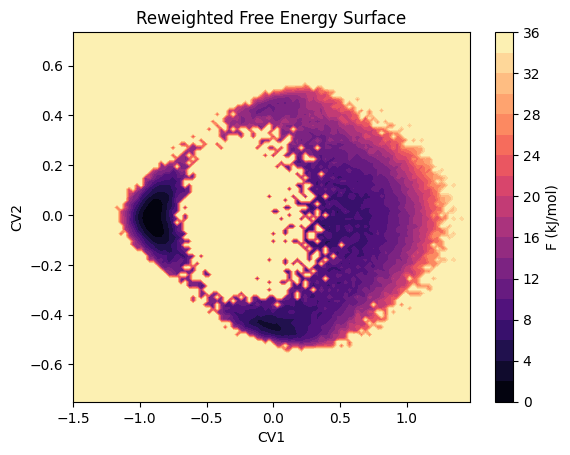

In [22]:
fes, x_edges, y_edges = get_free_energy_surface(data_df, "CV1", "CV2", temperature, kB, [[-1.5, 1.5], [-0.75, 0.75]])
plt.contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=20, cmap='magma')
plt.xlabel("CV1")
plt.ylabel("CV2")
plt.title("Reweighted Free Energy Surface")
plt.colorbar(label="F (kJ/mol)")
plt.show()

In [23]:
data_df["d1"] = CVs[:, 0]
data_df["d2"] = CVs[:, 1]
data_df["dih4"] = CV_O[:, 0]
data_df["dih3"] = CV_O[:, 1]
data_df["dih2"] = CV_O[:, 2]
data_df["dih1"] = CV_O[:, 3]

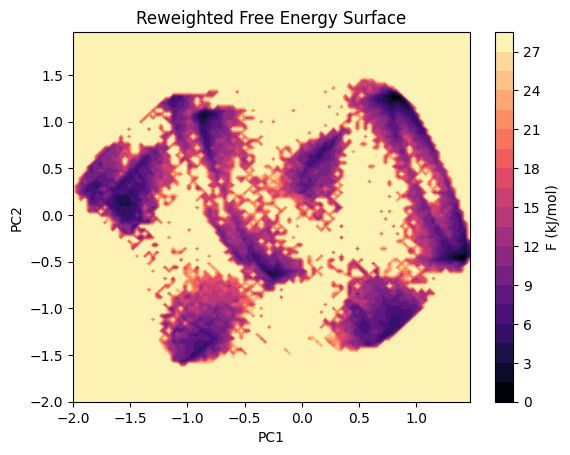

In [24]:
fes, x_edges, y_edges = get_free_energy_surface(data_df, "d1", "d2", temperature, kB, [[-2, 1.5], [-2, 2]])
plt.contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=20, cmap='magma')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Reweighted Free Energy Surface")
plt.colorbar(label="F (kJ/mol)")
plt.show()


In [25]:
FE_metad = np.load("/home/arminshzd/Documents/GADES/examples/sulfadiazine/PCA/metad_FE.npy")

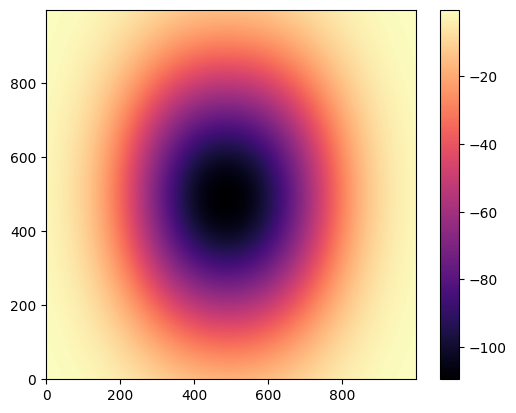

In [26]:
plt.imshow(FE_metad, cmap='magma', norm='linear', aspect='equal', interpolation='none', origin='lower')
plt.colorbar()
plt.show()

In [27]:
traj = md.load("/home/arminshzd/Documents/GADES/examples/sulfadiazine/traj_unbiased.dcd", top="../em.gro")
X = torch.from_numpy(traj.xyz)

In [28]:
CVs_O_ub, CVs, kds = get_colvars(traj)

In [29]:
unbiased_df = pd.DataFrame({'CV1': CVs[:, 0], 'CV2': CVs[:, 1], "weight": np.ones(CVs.shape[0], ), "dih1": CVs_O_ub[:, 0], "dih2": CVs_O_ub[:, 1], "dih3": CVs_O_ub[:, 2], "dih4": CVs_O_ub[:, 3]})

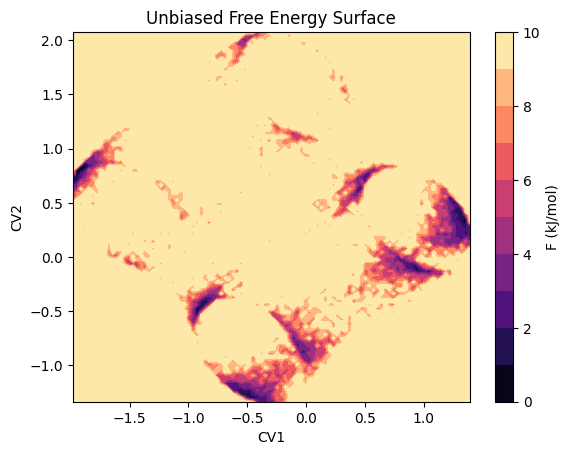

In [33]:
fes, x_edges, y_edges = get_free_energy_surface(unbiased_df, "CV1", "CV2", temperature, kB, None)
plt.contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=10, cmap='magma')
plt.xlabel("CV1")
plt.ylabel("CV2")
plt.title("Unbiased Free Energy Surface")
plt.colorbar(label="F (kJ/mol)")
plt.show()

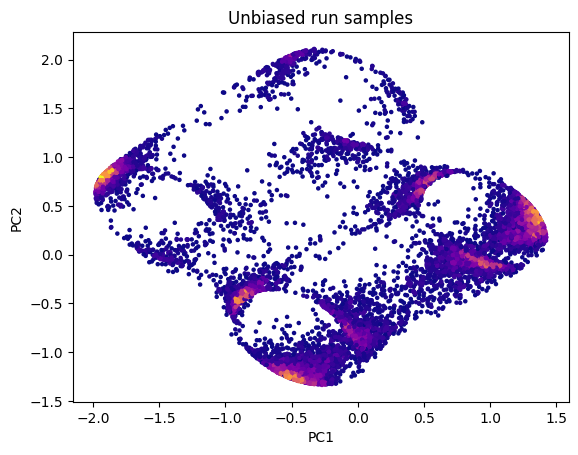

In [35]:
plt.scatter(CVs[:, 0], CVs[:, 1], c=kds, cmap="plasma", s=5)
plt.title("Unbiased run samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [36]:
traj = md.load("../traj_2000_2500.dcd", top="../em.gro")
X = torch.from_numpy(traj.xyz)
boxvectors = torch.from_numpy(traj.unitcell_vectors)

In [37]:
cv1_vals = torch.zeros(X.shape[0], )
cv2_vals = torch.zeros(X.shape[0], )
for i in range(X.shape[0]):
    with torch.no_grad():
        cv1_vals[i] = (cv1(X[i, ...], boxvectors[i, ...]))
        cv2_vals[i] = (cv2(X[i, ...], boxvectors[i, ...]))

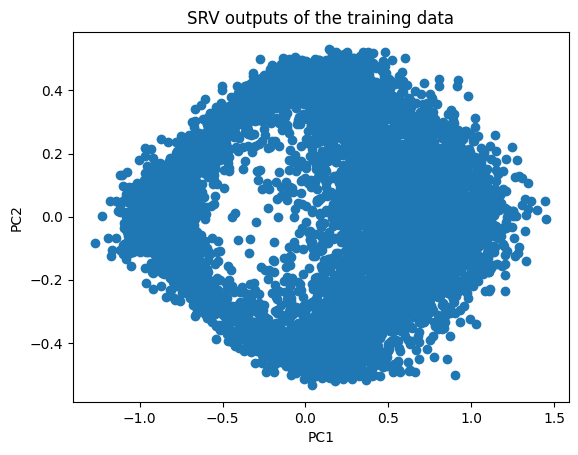

In [38]:
plt.scatter(cv1_vals, cv2_vals)
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.title("SRV outputs of the training data")
plt.show()

In [39]:
CVs_O, CVs, kds = get_colvars(traj)

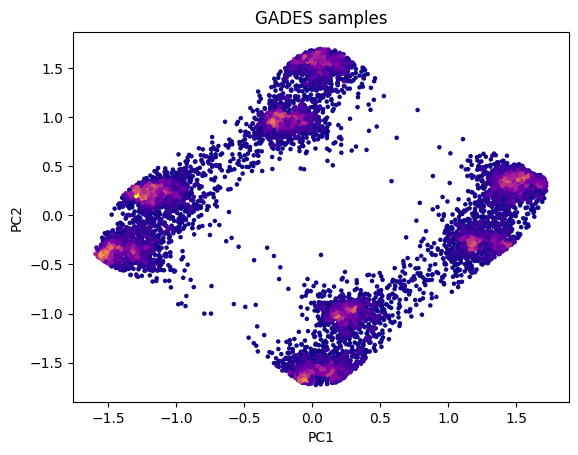

In [40]:
plt.scatter(CVs[:, 0], CVs[:, 1], c=kds, cmap="plasma", s=5)
plt.title("GADES samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

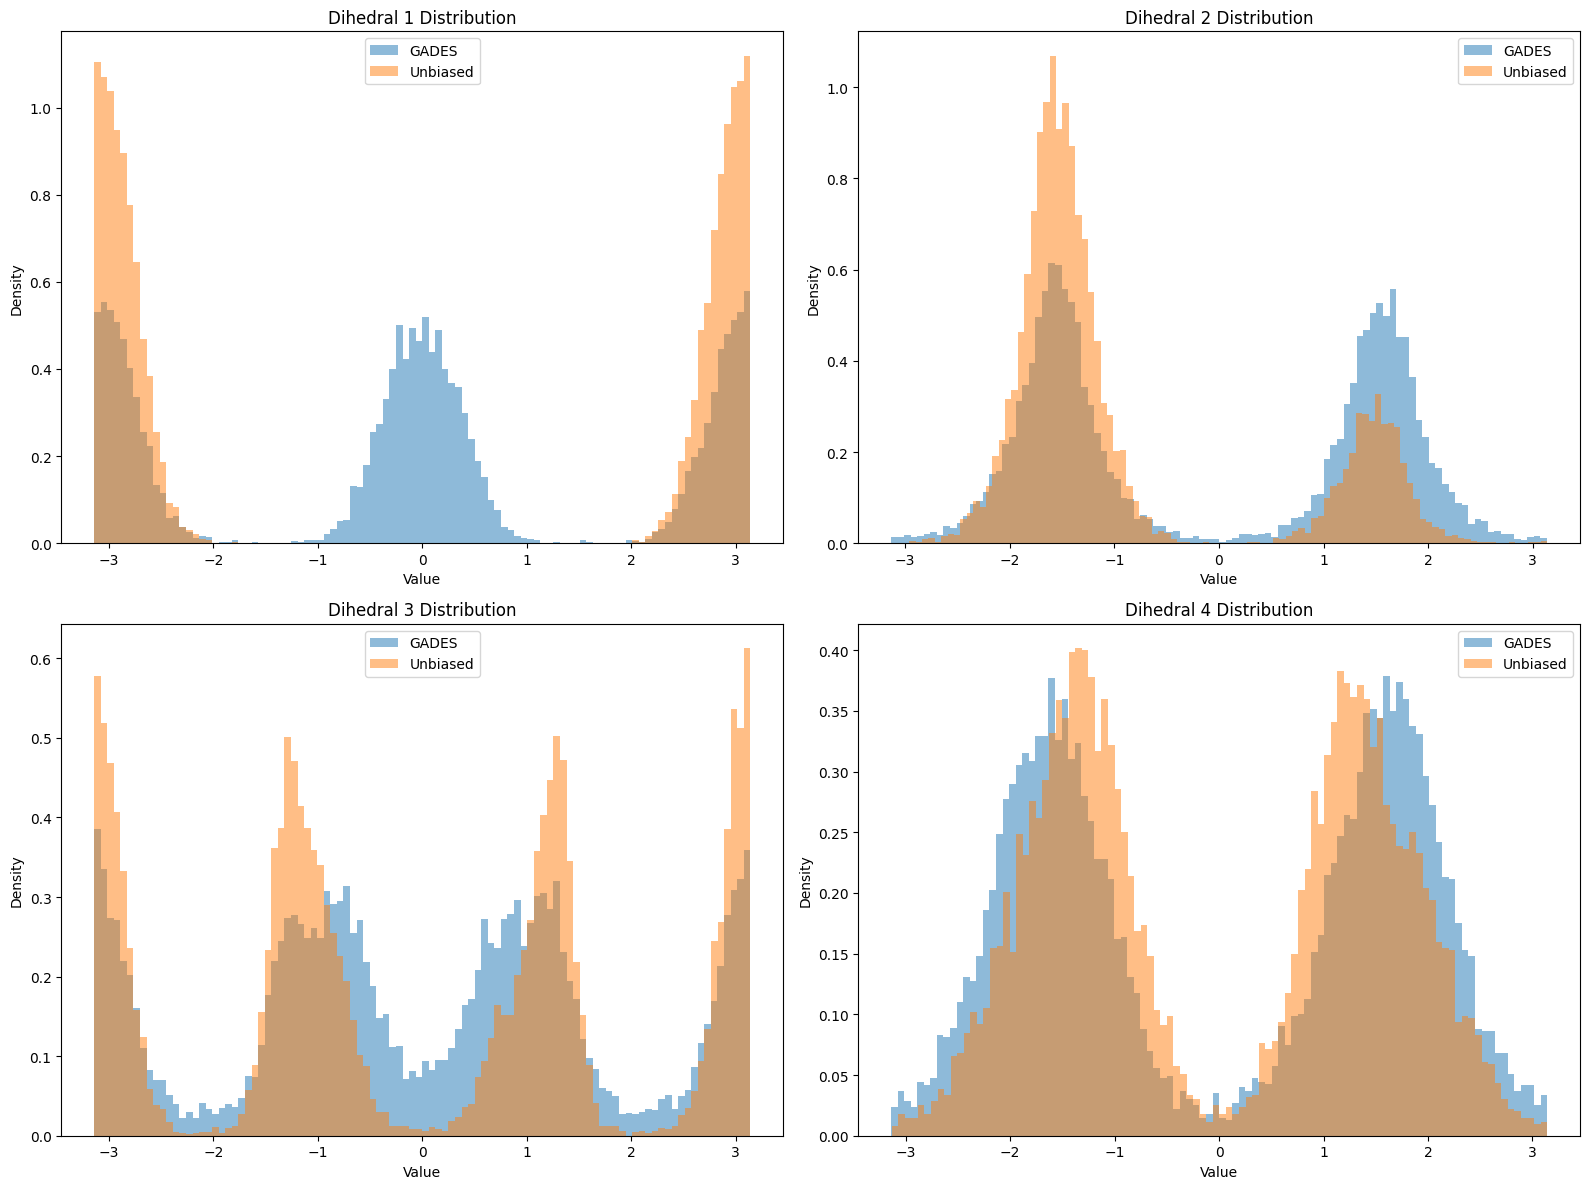

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].hist(CVs_O[:, i], bins=100, density=True, alpha=0.5, label=f'GADES')
    axs[i].hist(CVs_O_ub[:, i], bins=100, density=True, alpha=0.5, label=f'Unbiased')
    axs[i].legend()
    axs[i].set_title(f'Dihedral {i+1} Distribution')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Density')
plt.tight_layout()
plt.show()

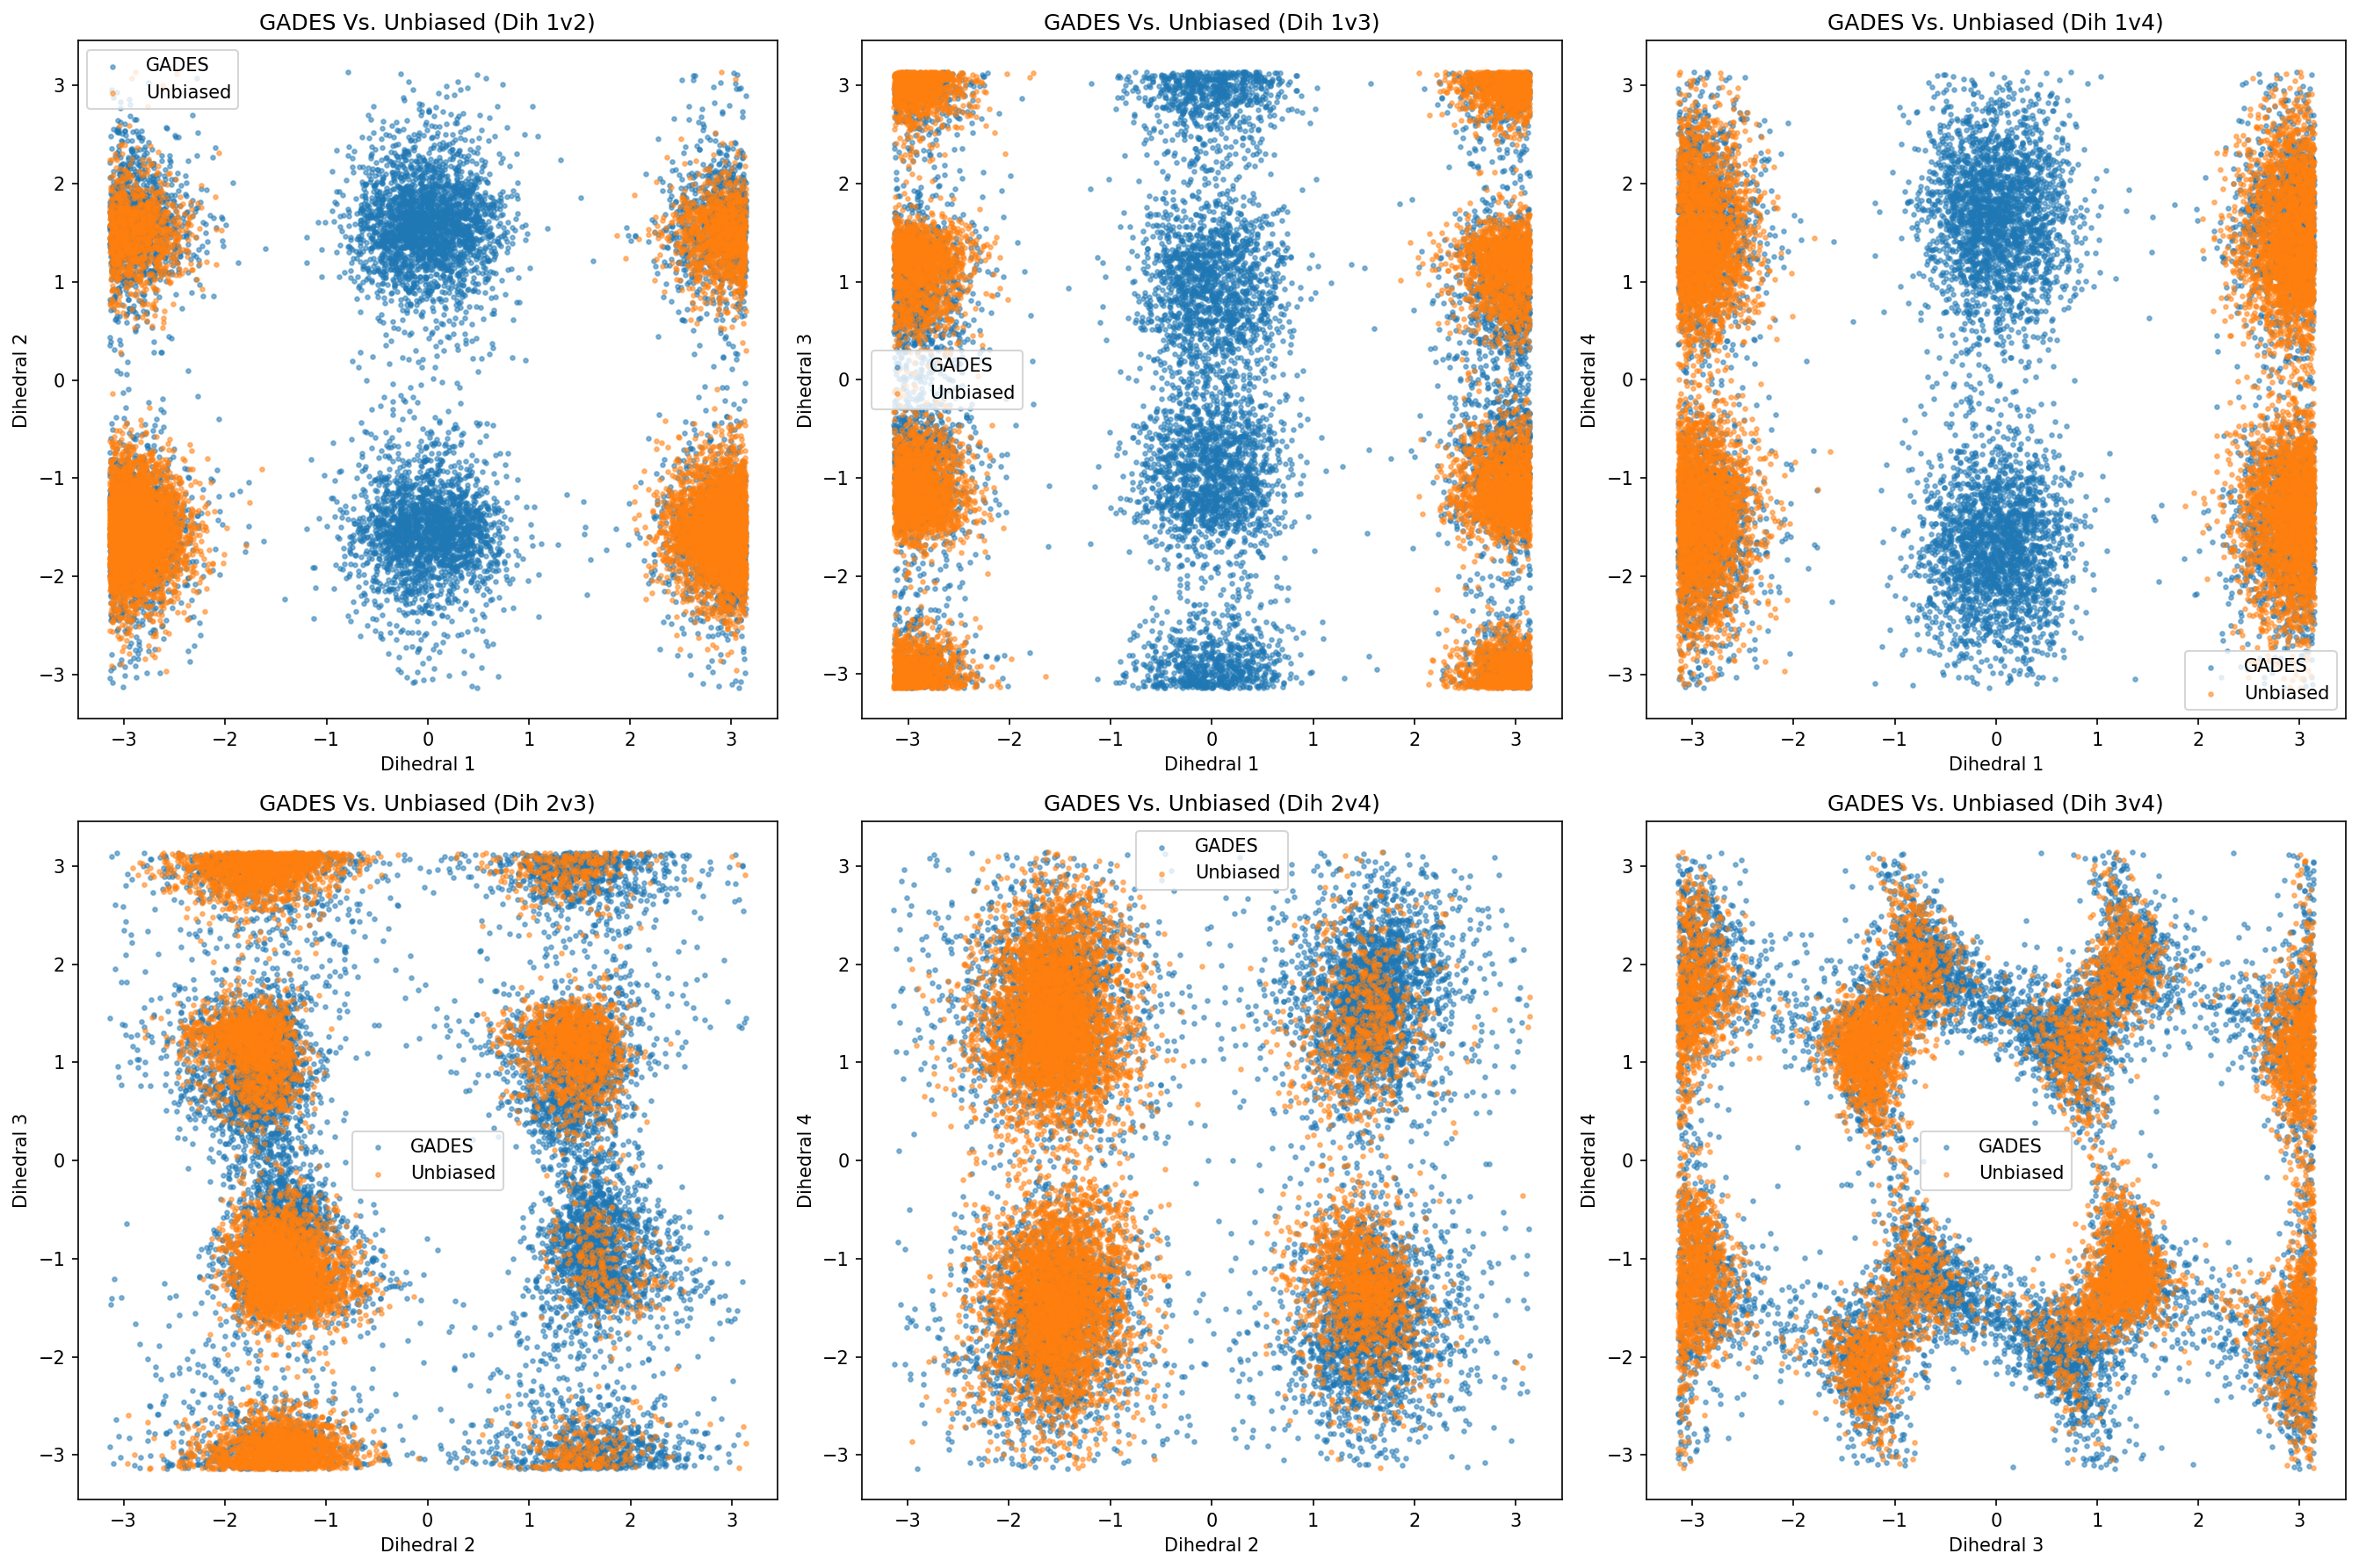

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12), dpi=150)
axs = axs.flatten()
alpha =0.5
axs[0].scatter(CVs_O[:, 0], CVs_O[:, 1], s=5, alpha=alpha, label='GADES')
axs[0].scatter(CVs_O_ub[:, 0], CVs_O_ub[:, 1], s=5, alpha=alpha, label='Unbiased')
axs[0].legend()
axs[0].set_title("GADES Vs. Unbiased (Dih 1v2)")
axs[0].set_xlabel("Dihedral 1")
axs[0].set_ylabel("Dihedral 2")
axs[1].scatter(CVs_O[:, 0], CVs_O[:, 2], s=5, alpha=alpha, label='GADES')
axs[1].scatter(CVs_O_ub[:, 0], CVs_O_ub[:, 2], s=5, alpha=alpha, label='Unbiased')
axs[1].legend()
axs[1].set_title("GADES Vs. Unbiased (Dih 1v3)")
axs[1].set_xlabel("Dihedral 1")
axs[1].set_ylabel("Dihedral 3")
axs[2].scatter(CVs_O[:, 0], CVs_O[:, 3], s=5, alpha=alpha, label='GADES')
axs[2].scatter(CVs_O_ub[:, 0], CVs_O_ub[:, 3], s=5, alpha=alpha, label='Unbiased')
axs[2].legend()
axs[2].set_title("GADES Vs. Unbiased (Dih 1v4)")
axs[2].set_xlabel("Dihedral 1")
axs[2].set_ylabel("Dihedral 4")
axs[3].scatter(CVs_O[:, 1], CVs_O[:, 2], s=5, alpha=alpha, label='GADES')
axs[3].scatter(CVs_O_ub[:, 1], CVs_O_ub[:, 2], s=5, alpha=alpha, label='Unbiased')
axs[3].legend()
axs[3].set_title("GADES Vs. Unbiased (Dih 2v3)")
axs[3].set_xlabel("Dihedral 2")
axs[3].set_ylabel("Dihedral 3")
axs[4].scatter(CVs_O[:, 1], CVs_O[:, 3], s=5, alpha=alpha, label='GADES')
axs[4].scatter(CVs_O_ub[:, 1], CVs_O_ub[:, 3], s=5, alpha=alpha, label='Unbiased')
axs[4].legend()
axs[4].set_title("GADES Vs. Unbiased (Dih 2v4)")
axs[4].set_xlabel("Dihedral 2")
axs[4].set_ylabel("Dihedral 4")
axs[5].scatter(CVs_O[:, 2], CVs_O[:, 3], s=5, alpha=alpha, label='GADES')
axs[5].scatter(CVs_O_ub[:, 2], CVs_O_ub[:, 3], s=5, alpha=alpha, label='Unbiased')
axs[5].legend()
axs[5].set_title("GADES Vs. Unbiased (Dih 3v4)")
axs[5].set_xlabel("Dihedral 3")
axs[5].set_ylabel("Dihedral 4")
plt.tight_layout()
plt.show()